**prerequisite**
1. 지역에 따라서 선호하는 게임 장르가 다를까?
2. 연도별 게임의 트렌드가 있을까?
3. 출고량이 높은 게임에 대한 분석 및 시각화 프로세스

**Goal**
- 목표 : 다음 분기에 어떤 게임을 설계해야 할까?
- 대상자 : 비데이터 직군

**Columns**
Name : 게임의 이름입니다.  
Platform : 게임이 지원되는 플랫폼의 이름입니다.  
Year : 게임이 출시된 연도입니다.  
Genre : 게임의 장르입니다.  
Publisher : 게임을 제작한 회사입니다.  
NA_Sales : 북미지역에서의 출고량입니다.  
EU_Sales : 유럽지역에서의 출고량입니다.  
JP_Sales : 일본지역에서의 출고량입니다.  
Other_Sales : 기타지역에서의 출고량입니다.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import *

url = 'https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/datasets/vgames2.csv'
df = pd.read_csv(url, parse_dates=['Year'], index_col=0)
df.head()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
1,Candace Kane's Candy Factory,DS,2008,Action,Destineer,0.04,0,0,0
2,The Munchables,Wii,2009,Action,Namco Bandai Games,0.17,0,0,0.01
3,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010,Adventure,Alchemist,0,0,0.02,0
4,Deal or No Deal: Special Edition,DS,2010,Misc,Zoo Games,0.04,0,0,0
5,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010,Platform,D3Publisher,0.12,0.09,0,0.04


**데이터 타입 확인 및 변경**
1. Object : Name, Platform, Genre, Publisher
2. Date(%Y) : Year
3. Float : NA_Sales, EU_Sales, JP_Sales, Other_Sales

(Null값 존재 시, 처리 후 변경 필요)

Year / Genre / Publisher Null값 존재

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16598 entries, 1 to 16598
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Name         16598 non-null  object
 1   Platform     16598 non-null  object
 2   Year         16327 non-null  object
 3   Genre        16548 non-null  object
 4   Publisher    16540 non-null  object
 5   NA_Sales     16598 non-null  object
 6   EU_Sales     16598 non-null  object
 7   JP_Sales     16598 non-null  object
 8   Other_Sales  16598 non-null  object
dtypes: object(9)
memory usage: 1.3+ MB


In [3]:
# Sales Data 타입 변경
# - Null값이 없음
# - 문자열 존재 가능성 높음
target_columns = df.columns[5:9]
chr_check = pd.DataFrame()

for col in target_columns:
    chr_check[col] = df[col].str.contains('[a-zA-Z]+')

chr_check.any(axis=1).value_counts()

False    15813
True       785
dtype: int64

In [4]:
temp = pd.DataFrame()
for col in target_columns:
    temp[col] = df[col].str.extract(r'([a-zA-Z]+)')
    print(temp[col].unique())

[nan 'K' 'M']
[nan 'M' 'K']
[nan 'K' 'M']
[nan 'M' 'K']


In [5]:
# 문자열 K, M만 있다는 것을 확인
# K는 10^3으로 M은 10^6으로 변경
for col in target_columns:
    df[col] = df[col].replace({'K':'*1e3','M':'*1e6'}, regex=True).map(pd.eval).astype(float)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16598 entries, 1 to 16598
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         16598 non-null  object 
 1   Platform     16598 non-null  object 
 2   Year         16327 non-null  object 
 3   Genre        16548 non-null  object 
 4   Publisher    16540 non-null  object 
 5   NA_Sales     16598 non-null  float64
 6   EU_Sales     16598 non-null  float64
 7   JP_Sales     16598 non-null  float64
 8   Other_Sales  16598 non-null  float64
dtypes: float64(4), object(5)
memory usage: 1.3+ MB


**2. 데이터 결측치 처리**
1. Year 
2. Publisher [프로젝트 목적에 필요 없기 때문에 처리 가능]
3. Genre 

- 결측치 데이터는 나중에 활용할 가능성이 있으니 따로 저장해둠  
- Table : missing_table


In [6]:
missing = df.isnull().sum().sort_values(ascending = 0)
missing

Year           271
Publisher       58
Genre           50
Name             0
Platform         0
NA_Sales         0
EU_Sales         0
JP_Sales         0
Other_Sales      0
dtype: int64

In [7]:
# 결측치 데이터 따로 저장
cond1 = df['Year'].isna() == True
cond2 = df['Publisher'].isna() == True
cond3 = df['Genre'].isna() == True
missing_table = df[ cond1 | cond2 | cond3 ]

In [8]:
# Publisher Null Data 처리
df['Publisher'].fillna('Unknown', inplace=True)

In [12]:
# NULL값과 데이터 비 
missing_table.shape[0] / df.shape[0] * 100
df.dropna(inplace=True)

In [13]:
# Year 자리 수 처리
import datetime
now = datetime.datetime.now().strftime(format='%y')

p_Year = ['20'+data[-2:] if data[-2:]<now else '19'+data[-2:] for i,data in enumerate(df['Year'])]     

df['Year'] = p_Year



In [14]:
df.isnull().sum()

Name           0
Platform       0
Year           0
Genre          0
Publisher      0
NA_Sales       0
EU_Sales       0
JP_Sales       0
Other_Sales    0
dtype: int64

**지역에 따라서 선호하는 게임 장르가 다를까?**

H0 = 지역과 게임 장르 사이 상관관계가 없다.  
H1 = 지역과 게임 장르 사이 상관관계가 있다.


- 위와 같은 가설 검증을 위해 Chisquare를 이용한다.  
- H1 채택시 국가별 장르 선호도를 확인 해본다.

In [15]:
p1_table = df.loc[:,['Genre','NA_Sales','EU_Sales','JP_Sales','Other_Sales']]

grouped_p1 = p1_table.groupby('Genre')
# grouped_p1.reset_index(inplace=True)
marketsize =  grouped_p1.sum()
marketsize

,NA_Sales,EU_Sales,JP_Sales,Other_Sales
Genre,,,,
Action,21470837.31,7030506.61,1440155.17,1340182.65
Adventure,760101.16,190063.52,80051.81,280016.42
Fighting,1360218.99,1420098.48,1340085.80,500035.65
Misc,4090396.20,2820207.38,420103.76,460072.28
Platform,5220440.16,7620193.03,790129.74,480050.97
Puzzle,80121.50,410050.07,56.24,50012.39
Racing,11950342.75,2040232.99,280056.04,420076.09
Role-Playing,1600317.16,1610181.49,11780331.15,1620055.11
Shooter,12430562.05,6120304.11,60038.12,740101.12


In [16]:
from scipy.stats import chi2_contingency, chisquare
chi2, p, dof, expected = chi2_contingency(grouped_p1.mean())
msg = 'Test Statistic: {}\np-value: {}\nDegree of Freedom: {}'
print(msg.format(chi2, p, dof))

Test Statistic: 49258.8781647331
p-value: 0.0
Degree of Freedom: 33


In [17]:
col = ['NA_Sales','EU_Sales','JP_Sales','Other_Sales']
ind = grouped_p1.indices

scaler = StandardScaler()
Z_sum = pd.DataFrame(scaler.fit_transform(grouped_p1.sum()), columns=col, index=ind)
Z_mean = pd.DataFrame(scaler.fit_transform(grouped_p1.mean()), columns=col, index=ind)

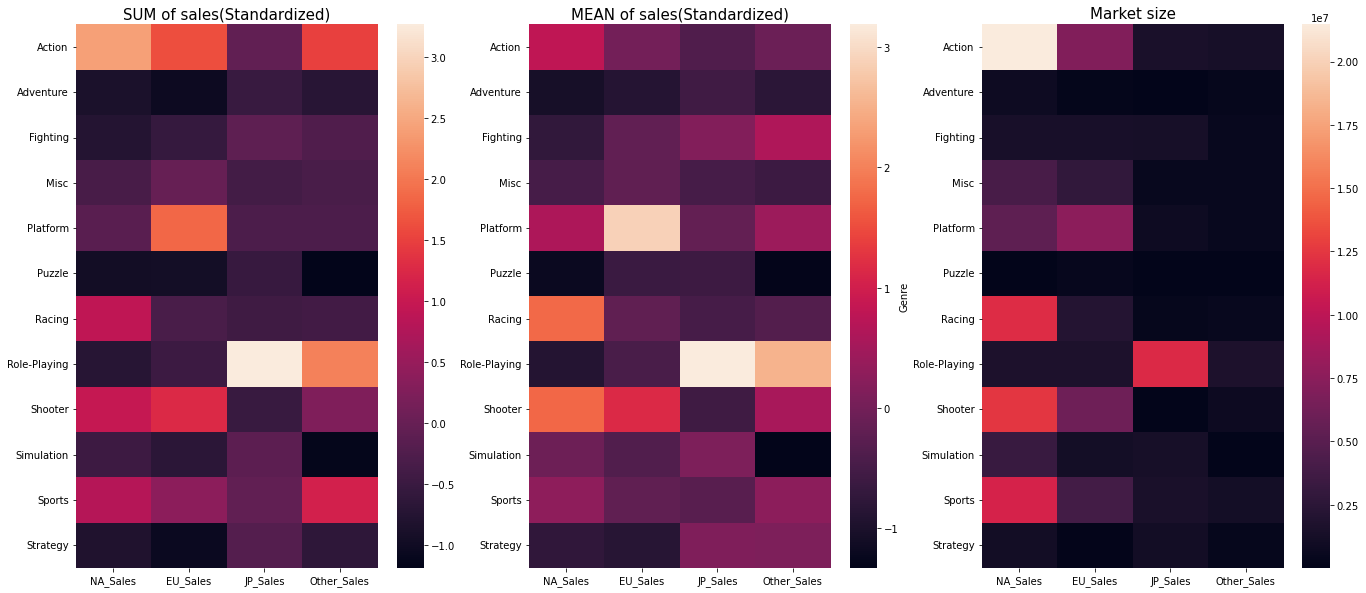

In [18]:
plt.figure(figsize=(23,10))
plt.subplot(131)
plt.title('SUM of sales(Standardized)', fontdict={'size':15})
sns.heatmap(Z_sum)
plt.subplot(132)
plt.title('MEAN of sales(Standardized)', fontdict={'size':15})
sns.heatmap(Z_mean)
plt.subplot(133)
plt.title('Market size', fontdict={'size':15})
sns.heatmap(marketsize)
plt.show()


<AxesSubplot:title={'center':'Market size by genre'}, xlabel='variable', ylabel='value'>

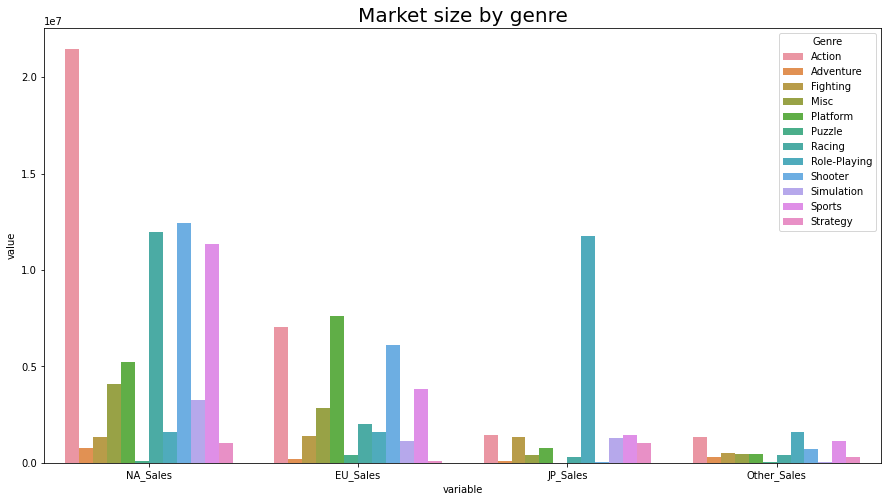

In [19]:
marketsize.reset_index(inplace=True)
melted_ = marketsize.melt(id_vars='Genre', value_vars=['NA_Sales','EU_Sales','JP_Sales','Other_Sales'])
plt.figure(figsize=(15,8))
plt.title('Market size by genre', fontdict={'size':20})
sns.barplot(data=melted_, x='variable', y='value', hue='Genre')

ANS 1. 지역과 장르와의 관계에 있어 연관성이 있음 (p-value 0.05이하)  
    2. 전반적으로 북미 시장이 타지역보다 잘 형성이 되어 있다.  
    - 북미 : 액션, 레이싱, 슈팅, 스포츠에서 매출이 많이 나왔으며, 관심도는 레이싱과 슈팅가 높다고 볼 수 있다.  
    - 유럽 : 액션, 플랫폼, 슈팅, 스포츠에서 매출이 많이 나왔으며, 플랫폼과 슈팅 게임에 대한 관심도가 높다고 볼 수 있다.  
    - 일본 : 롤플레잉 게임에 집중 되어있으며, 그 외 스포츠, 액션, 슈팅게임 정도가 활성화 되어 있다.  
    - 그 외의 국가들은 시장의 규모가 작으나, 그 중에서도 롤플레잉에 집중도가 높다고 볼 수 있다.  

**연도별 게임의 트렌드가 있을까?**

H0 : 연도별 게임의 트렌드가 없다.  
H1 : 연도별 게임의 트렌드가 있다.

In [20]:
# 날짜 기준 테이블 생성 및 연도 파싱
p2_table = df.loc[:,['Year','NA_Sales','EU_Sales','JP_Sales','Other_Sales']]

grouped_p2 = p2_table.groupby('Year')
sum_p2 = grouped_p2.sum()
mean_p2 = grouped_p2.median()

In [21]:
chi2, p, dof, expected = chi2_contingency(grouped_p2.mean())
msg = 'Test Statistic: {}\np-value: {}\nDegree of Freedom: {}'
print(msg.format(chi2, p, dof))

Test Statistic: 400592.60491074756
p-value: 0.0
Degree of Freedom: 114


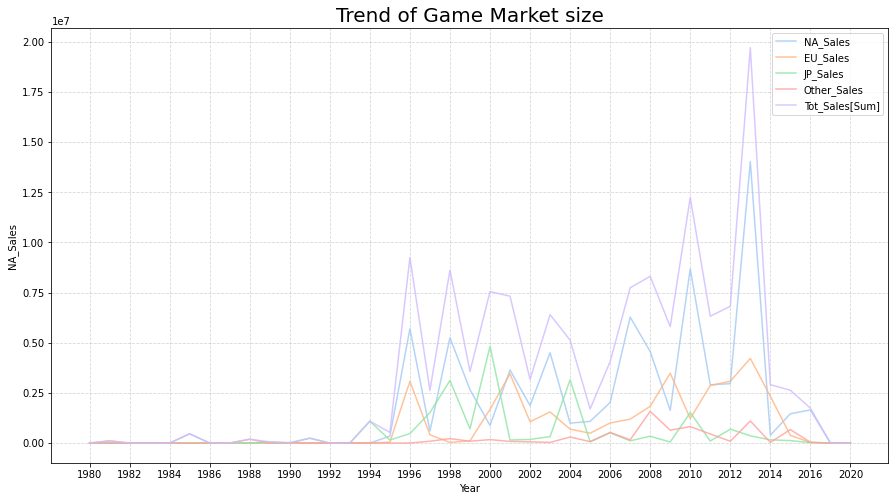

In [45]:
sum_p2['Tot_Sales[Sum]'] = sum_p2['NA_Sales'] + sum_p2['EU_Sales'] + sum_p2['JP_Sales'] + sum_p2['Other_Sales']
sum_p2['Tot_Sales[Median]'] = mean_p2['NA_Sales'] + mean_p2['EU_Sales'] + mean_p2['JP_Sales'] + mean_p2['Other_Sales']

sns.set_palette('pastel')
fig, ax1 = plt.subplots(figsize=(15,8))
plt.title('Trend of Game Market size', fontdict={'size':20})
for col in sum_p2.columns[0:-1]:
    sns.lineplot(x=sum_p2.index, y=sum_p2[col], label=col, alpha=0.8, ax=ax1)
plt.xticks(np.arange(0,40,2))
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

In [23]:
print('after 2015, # of data ratio : ',df[df['Year']>'2014'].shape[0]/df['Year'].shape[0]*100,'%')


after 2015, # of data ratio :  5.891749093813356 %


- 2014년 이후로 하락하는 모양이 있으나 이것은 데이터가 부족해서 발생하는 현상으로 보인다.
- 게임 시장은 꾸준히 규모가 커져 왔으며, 이는 북미 게임 시장의 성장과 맞물려 있다. 

**출고량이 높은 게임에 대한 분석 및 시각화 프로세스**


In [24]:
df['Tot_Sales'] = df[['NA_Sales','EU_Sales','JP_Sales','Other_Sales']].sum(axis=1)
df

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Tot_Sales
1,Candace Kane's Candy Factory,DS,2008,Action,Destineer,0.04,0.00,0.00,0.00,0.04
2,The Munchables,Wii,2009,Action,Namco Bandai Games,0.17,0.00,0.00,0.01,0.18
3,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010,Adventure,Alchemist,0.00,0.00,0.02,0.00,0.02
4,Deal or No Deal: Special Edition,DS,2010,Misc,Zoo Games,0.04,0.00,0.00,0.00,0.04
5,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010,Platform,D3Publisher,0.12,0.09,0.00,0.04,0.25
...,...,...,...,...,...,...,...,...,...,...
16594,Ice Age 2: The Meltdown,GC,2006,Platform,Vivendi Games,0.15,0.04,0.00,0.01,0.20
16595,Rainbow Islands: Revolution,PSP,2005,Action,Rising Star Games,0.01,0.00,0.00,0.00,0.01
16596,NBA 2K16,PS3,2015,Sports,Take-Two Interactive,0.44,0.19,0.03,0.13,0.79
16597,Toukiden: The Age of Demons,PSV,2013,Action,Tecmo Koei,0.05,0.05,0.25,0.03,0.38


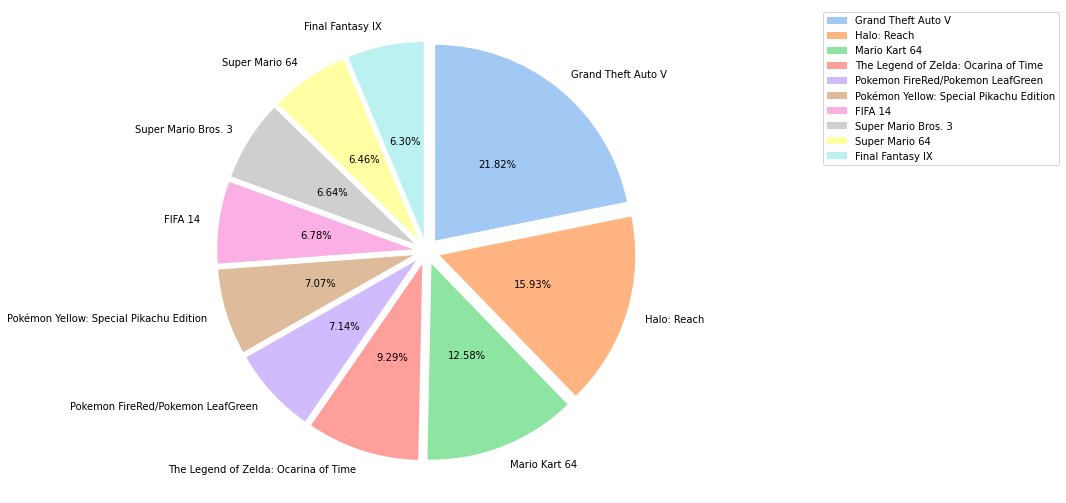

In [25]:
p3_table = df.groupby('Name')['Tot_Sales'].sum().sort_values(ascending=False)
filter_p3 = p3_table.head(10)

pie, ax = plt.subplots(figsize=(15,9))
labels = filter_p3.keys()
plt.pie(x=filter_p3, startangle=90, counterclock=False, autopct='%.2f%%', explode=[0.07]*len(filter_p3), labels=labels, pctdistance=0.5);
plt.yticks(color='#00517C')
plt.legend( bbox_to_anchor=(1.3, 1))

In [26]:
top10_list = filter_p3.reset_index().Name

# temp = pd.DataFrame(columns = df.columns)
top10_df = pd.DataFrame()
for val in top10_list:
    top10_df = top10_df.append([df.loc[df['Name'] == val]], ignore_index=True)
top10_df

C:\Users\jsm88\AppData\Local\Temp/ipykernel_9068/1553370004.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top10_df = top10_df.append([df.loc[df['Name'] == val]], ignore_index=True)


,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Tot_Sales
0,Grand Theft Auto V,PS4,2014,Action,Take-Two Interactive,3.80,5.81,0.36,2.02,11.99
1,Grand Theft Auto V,PS3,2013,Action,Take-Two Interactive,7.01,9.27,0.97,4.14,21.39
2,Grand Theft Auto V,XOne,2014,Action,Take-Two Interactive,2.66,2.01,0.00,0.41,5.08
3,Grand Theft Auto V,X360,2013,Action,Take-Two Interactive,9630000.00,5.31,0.06,1.38,9630006.75
4,Grand Theft Auto V,PC,2015,Action,Take-Two Interactive,0.36,0.64,0.00,0.08,1.08
5,Halo: Reach,X360,2010,Shooter,Microsoft Game Studios,7030000.00,1.98,0.08,0.78,7030002.84
6,Mario Kart 64,N64,1996,Racing,Nintendo,5550000.00,1.94,2.23,0.15,5550004.32
7,The Legend of Zelda: Ocarina of Time,N64,1998,Action,Nintendo,4100000.00,1.89,1.45,0.16,4100003.50
8,The Legend of Zelda: Ocarina of Time,3DS,2011,Action,Nintendo,2.03,1.27,0.62,0.30,4.22
9,Pokemon FireRed/Pokemon LeafGreen,GBA,2004,Role-Playing,Nintendo,4.34,2.65,3150000.00,0.35,3150007.34


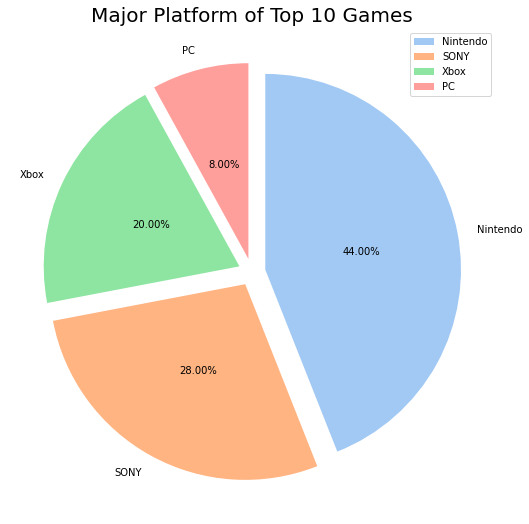

In [27]:

Nintendo = ['N64', '3DS','Wii', 'NES', 'DS', 'GBA', 'GB']
Xbox = ['X360','XOne']
SONY = ['PS4','PS3','PS','PSP','PSV']
PC = ['PC']

top10_df['Platform'].replace({'N64' : 'Nintendo', '3DS' : 'Nintendo', 'Wii' : 'Nintendo', 'NES' : 'Nintendo', 'DS' : 'Nintendo', 'GBA' : 'Nintendo', 'GB' : 'Nintendo'}, inplace=True)
top10_df['Platform'].replace({'X360' : 'Xbox', 'XOne' : 'Xbox'}, inplace=True)
top10_df['Platform'].replace({'PS4' : 'SONY', 'PS3' : 'SONY', 'PS' : 'SONY', 'PSP' : 'SONY', 'PSV' : 'SONY'}, inplace=True)
pie_platform = top10_df['Platform'].value_counts()

pie, ax = plt.subplots(figsize=(15,9))
labels = pie_platform.keys()

plt.pie(pie_platform, startangle=90, counterclock=False, autopct='%.2f%%', explode=[0.07]*len(pie_platform), labels=pie_platform.index, pctdistance=0.5);
plt.title('Major Platform of Top 10 Games', fontdict={'size':20})
plt.legend()

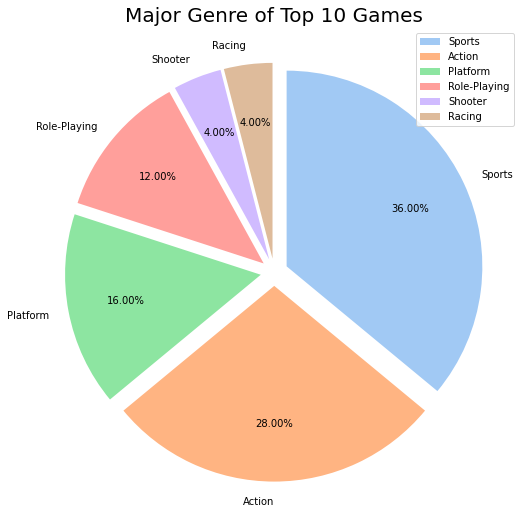

In [28]:
pie_Genre = top10_df['Genre'].value_counts()

pie, ax = plt.subplots(figsize=(15,9))
labels = pie_Genre.keys()

plt.pie(pie_Genre, startangle=90, counterclock=False, autopct='%.2f%%', explode=[0.07]*len(pie_Genre), labels=pie_Genre.index, pctdistance=0.7);
plt.title('Major Genre of Top 10 Games', fontdict={'size':20})
plt.legend()

In [29]:
df[df['Year']>'2014']['Platform'].value_counts()

PS4     244
PSV     175
XOne    132
3DS     121
PS3     105
PC       88
X360     48
WiiU     38
Wii       4
PSP       3
DS        1
Name: Platform, dtype: int64

**결론**
- 게임 시장은 지금까지 북미시장에 대한 의존도가 굉장히 높았으며, 
- 게임에 대한 인식과 사회 인프라가 깔리기 까지 5년 정도의 오랜 시간이 걸리기에 향후 몇 년간 이 추세는 계속 지속 될 것으로 보입니다.
- 또한 지금까지의 대작 게임을 보았을 때 닌텐도플랫폼이 많이 점유를 하였으나, 최근에는 SONY 플랫폼을 많이 이용하는 것으로 보입니다. 
- 지금까지 대작 게임들은 확실한 IP를 바탕으로 만들어 진 것들이 많다.(포켓몬스터, 파이널판타지, 젤다, 슈퍼마리오, FIFA 등)

- 다음 시즌 게임을 출시를 한다고 하면, 앞서 나온 영향력들을 바탕으로 북미지역과 유럽을 같이 아우를 수 있는 액션, 스포츠류의 게임을 우선적으로 소니 플레이스테이션 플랫폼에 만드는 것이 적절합니다.
- 또한 최근 인기 있는 게임들은 멀티플랫폼으로 운영을 주로 하고 있기 때문에 이점 염두 해 두어야 합니다. 